### Read the DeepMind AQUA Data Set (.json file)

In [1]:
import pandas as pd
import numpy as np
import json 

import nltk
import string

In [2]:
qb =  pd.read_json('AQuA-master/dev.json',lines=True)
qb.columns

Index(['correct', 'options', 'question', 'rationale'], dtype='object')

In [3]:
qb.head()

,correct,options,question,rationale
0,A,"[A)32400, B)6000, C)600, D)60000, E)10]",Three birds are flying at a fast rate of 900 k...,To calculate the equivalent of miles in a kilo...
1,D,"[A)100 m, B)150 m, C)200 m, D)250 m, E)300 m]",A ship is leaving a port. It takes 240 seconds...,Let the length of the ship be x metres and its...
2,C,"[A)6, B)18, C)24, D)36, E)48]",A rectangular piece of cloth 2 feet wide was c...,"The question says, length of shorter piece is ..."
3,B,"[A)(1,1), B)(0,3), C)(2,0), D)(3,6), E)(6,3)]","In the xy-coordinate plane, which of the follo...",For a point to satisfy the given equation for ...
4,C,"[A)7, B)9, C)13, D)27, E)45]",A travel company wants to charter a plane to t...,"Additional passengers (i.e., an integer, let's..."


### Functions to remove the named entities 

In [4]:
def untokenize(tokens):
    return("".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip())

def extract_nonentities(tree):
    tokens = [leaf[0] for leaf in tree if type(leaf) != nltk.Tree]
    return(untokenize(tokens))

def ne_removal(text_list):
    token_list = [nltk.word_tokenize(text) for text in text_list]
    tagged = nltk.pos_tag_sents(token_list)
    chunked = nltk.ne_chunk_sents(tagged)
    non_entities = []
    for tree in chunked:
        non_entities.append(extract_nonentities(tree))
    return(non_entities)

In [5]:
# removal of named entities
qb['qn'] = ne_removal(qb['question'])


### Text Pre Processing 

In [6]:
## remove numerals , replace % with percent and convert to lowercase
import re
qb.qn = qb.qn.apply(lambda x: x.lower())
qb['qn'] = qb['qn'].apply(lambda x: re.sub(r'\%', 'percent', x))
qb['qn'] = qb['qn'].apply(lambda x: re.sub(r'\d+', '', x))

print(qb.qn.iloc[:3])

0    three birds are flying at a fast rate of  kilo...
1    a ship is leaving a port. it takes  seconds to...
2    a rectangular piece of cloth  feet wide was cu...
Name: qn, dtype: object


### count vectorizer

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(qb.qn) #train and get bag of words
print("Vocabulary size: {}".format(len(vectorizer.vocabulary_)))


Vocabulary size: 1550


In [8]:
questions=qb.question

In [9]:
import string
import collections
 
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint

### TFIDF vectorizer

In [10]:
# Instantiate the TFIDF vectorizer
word_vectorizer = TfidfVectorizer(
    stop_words='english',
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    max_features=30000)

# fit and transform on it the training features
tfidf_matrix = word_vectorizer.fit_transform(qb.qn)

print(tfidf_matrix.shape)

(254, 1381)


In [11]:
terms = word_vectorizer.get_feature_names()
#print(terms)


In [12]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print(dist)

[[ -2.22044605e-16   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00  -2.22044605e-16   9.61554447e-01 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   9.61554447e-01  -2.22044605e-16 ...,   1.00000000e+00
    1.00000000e+00   9.43485729e-01]
 ..., 
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,  -2.22044605e-16
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
   -2.22044605e-16   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   9.43485729e-01 ...,   1.00000000e+00
    1.00000000e+00  -2.22044605e-16]]


### KMeans Clustering 

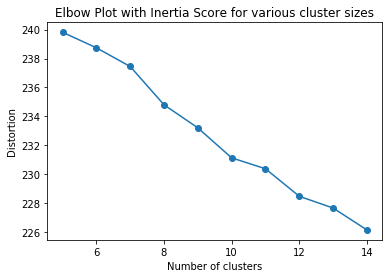

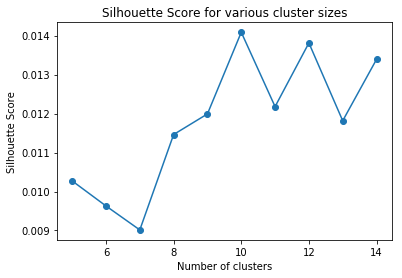

In [17]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline

sil_scores = []
distortions = []
for i in range (5,15):
    km = KMeans(n_clusters=i,random_state=10,verbose=0)
    Y = km.fit_predict(tfidf_matrix)
 
    distortions.append(km.inertia_)
    if (i>=2):
        sc = (metrics.silhouette_score(tfidf_matrix, Y))
        sil_scores.append(sc)

plt.plot(range(5,15), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("Elbow Plot with Inertia Score for various cluster sizes")
plt.show()


plt.plot(range(5,15), sil_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score for various cluster sizes")
plt.show()

In [18]:
km = KMeans(n_clusters=7,random_state=42,verbose=0)
clusters = km.fit_predict(tfidf_matrix)

In [19]:
print(len(clusters))
print(clusters)

254
[5 1 6 1 2 6 4 1 1 0 6 0 0 5 2 1 2 0 0 4 4 2 4 2 4 5 1 1 1 4 4 0 5 1 0 1 1
 4 6 3 4 1 1 4 1 4 4 0 1 1 5 2 2 2 0 4 2 1 5 1 6 5 3 1 3 1 5 1 4 3 1 2 6 6
 1 0 6 1 1 0 3 2 1 2 6 0 3 2 3 0 6 6 1 3 6 0 2 1 3 1 1 4 3 1 2 4 0 1 3 0 3
 5 1 5 1 2 0 6 5 4 5 1 5 1 1 0 1 4 4 1 2 1 6 1 1 1 5 6 0 1 2 1 0 1 1 6 0 0
 1 1 4 5 1 3 5 1 0 2 1 5 5 3 0 1 1 3 5 0 5 2 1 0 0 1 4 3 1 1 0 1 4 2 0 2 1
 0 6 4 5 1 1 5 6 1 0 1 4 1 6 1 4 6 3 0 5 1 0 4 2 1 3 3 5 2 5 4 1 4 4 6 2 1
 1 0 2 4 6 1 3 3 0 1 5 1 6 6 3 4 6 1 0 0 1 2 4 0 1 1 0 1 4 6 3 2]


In [20]:
qset = { 'question': qb.question, 'cluster': clusters }

frame = pd.DataFrame(qset, columns = ['question','cluster'])

In [21]:
frame.head()

,question,cluster
0,Three birds are flying at a fast rate of 900 k...,5
1,A ship is leaving a port. It takes 240 seconds...,1
2,A rectangular piece of cloth 2 feet wide was c...,6
3,"In the xy-coordinate plane, which of the follo...",1
4,A travel company wants to charter a plane to t...,2


In [22]:
frame['cluster'].value_counts()

1    79
0    39
4    33
2    28
6    26
5    26
3    23
Name: cluster, dtype: int64

### Lets look at the clusters in the question 

In [23]:
grouped = frame['question'].groupby(frame['cluster']) #groupby cluster for aggregation purposes
for key, item in grouped:
    print (grouped.get_group(key), "\n\n\n\n")

9      Solution A has 5% salt concentration and remai...
11     In how many arrangements can you arrange 3 gre...
12     In a mixture, the ratio of spirit and water is...
17     In a poll of 45,000 dentists, only 30 percent ...
18     In recent Malta elections, in a particular con...
31     A cube shaped pool is half full of water. If t...
34     At an elite baseball camp, 60% of players can ...
47     An agent gets a 5% commission on sales of clot...
54     30% of all Huhulians own at least one TV. 24% ...
75     In a mixture of milk and water, there is only ...
79     The ratio of A’s and B’s salary is 9 : 4. If A...
85     Vegetables contains 68% water and green vegeta...
89     x contains 85% water and 15% oil; how many mor...
95     In a shipment of 120 machine parts, 5 percent ...
106    John and Mike had equal amount of money in sav...
109    For a candidate to clear an examination, he/sh...
116    A sink contains exactly 11 liters of water. If...
125    Country Club has an indo

### Dimension Reduction of TFIDF matrix with SVD

In [24]:
def svd_tfidf_matrix(matrix):
    svd = TruncatedSVD(n_components=3)
    return svd.fit_transform(matrix)

In [26]:
from sklearn.decomposition import TruncatedSVD
svd_m = TruncatedSVD(n_components=100,  algorithm='randomized', n_iter=10, random_state=42)
svd = svd_m.fit_transform(tfidf_matrix)
print(svd.shape)

# Lets build the Clustering Model with this matrix
from nltk.cluster import KMeansClusterer
import nltk

kclusterer = KMeansClusterer(7, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(svd, assign_clusters=True)
print (assigned_clusters)


   

(254, 100)
[1, 0, 4, 2, 1, 3, 5, 1, 3, 5, 4, 4, 4, 1, 5, 0, 2, 5, 5, 5, 5, 1, 5, 6, 3, 0, 5, 0, 1, 4, 5, 3, 0, 0, 5, 6, 4, 5, 4, 2, 3, 1, 0, 5, 1, 3, 5, 3, 6, 4, 1, 2, 3, 3, 5, 2, 3, 2, 4, 1, 4, 0, 4, 1, 3, 6, 0, 6, 3, 6, 2, 3, 4, 4, 3, 5, 4, 6, 1, 4, 6, 2, 3, 5, 4, 5, 6, 1, 4, 5, 4, 4, 6, 4, 4, 5, 2, 4, 0, 1, 0, 2, 6, 0, 2, 5, 5, 3, 3, 3, 3, 0, 6, 0, 2, 2, 1, 4, 0, 5, 0, 5, 0, 6, 0, 0, 0, 5, 5, 5, 2, 0, 0, 2, 3, 4, 1, 2, 4, 2, 3, 4, 3, 3, 5, 5, 5, 3, 1, 6, 2, 0, 3, 3, 0, 3, 5, 4, 5, 2, 0, 1, 5, 3, 2, 6, 0, 4, 0, 3, 2, 5, 5, 0, 2, 1, 1, 3, 5, 3, 5, 2, 5, 5, 0, 5, 4, 5, 0, 0, 6, 1, 4, 0, 3, 6, 5, 3, 4, 5, 5, 3, 0, 5, 0, 3, 5, 2, 2, 1, 6, 1, 0, 0, 0, 3, 6, 4, 5, 4, 0, 0, 1, 4, 0, 2, 2, 4, 4, 4, 5, 5, 0, 3, 0, 4, 2, 3, 4, 3, 0, 5, 0, 1, 3, 5, 0, 5, 0, 2, 5, 4, 1, 2]


In [27]:
qset2 = { 'question': qb.question, 'cluster': assigned_clusters }

frame2 = pd.DataFrame(qset, columns = ['question','cluster'])

In [28]:
frame2['cluster'].value_counts()

1    79
0    39
4    33
2    28
6    26
5    26
3    23
Name: cluster, dtype: int64